**TFM - Latent space comparison between different generative models (VAE, GAN, StyleGAN...)**

In [60]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from IPython import display

In [43]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.2.2+cu121
CUDA version: 12.1
CUDA available: True
Number of GPUs: 1


Loading dataset

In [44]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


**VAE architecture**

In [6]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).cuda()   
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

Initialize VAE

In [7]:
model = VAE().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Loss function

In [9]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

Train model

In [10]:
def train(model, optimizer, epochs, x_dim=784):
    model.train()
    history = {'loss': []}  # Track loss
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).cuda()
            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        avg_loss = overall_loss/(batch_idx*batch_size)
        history['loss'].append(avg_loss)
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", avg_loss)
    return history

# Run and store training history
vae_history = train(model, optimizer, epochs=50)

	Epoch 1 	Average Loss:  177.45634097193238
	Epoch 2 	Average Loss:  157.16911760486227
	Epoch 3 	Average Loss:  152.13495857353402
	Epoch 4 	Average Loss:  149.24634178709306
	Epoch 5 	Average Loss:  147.36321271128966
	Epoch 6 	Average Loss:  145.94901161767007
	Epoch 7 	Average Loss:  144.8058501962907
	Epoch 8 	Average Loss:  143.96160578503233
	Epoch 9 	Average Loss:  143.01205427013772
	Epoch 10 	Average Loss:  142.41122544736018
	Epoch 11 	Average Loss:  141.90475548440108
	Epoch 12 	Average Loss:  141.19111383555926
	Epoch 13 	Average Loss:  140.7301779332742
	Epoch 14 	Average Loss:  140.22761019342133
	Epoch 15 	Average Loss:  139.82943056135224
	Epoch 16 	Average Loss:  139.5274189078151
	Epoch 17 	Average Loss:  139.23690315565005
	Epoch 18 	Average Loss:  138.7499823599228
	Epoch 19 	Average Loss:  138.42341756116966
	Epoch 20 	Average Loss:  138.00272995682909
	Epoch 21 	Average Loss:  137.79962072203674
	Epoch 22 	Average Loss:  137.45888169736017
	Epoch 23 	Average Loss

VAE loss curves

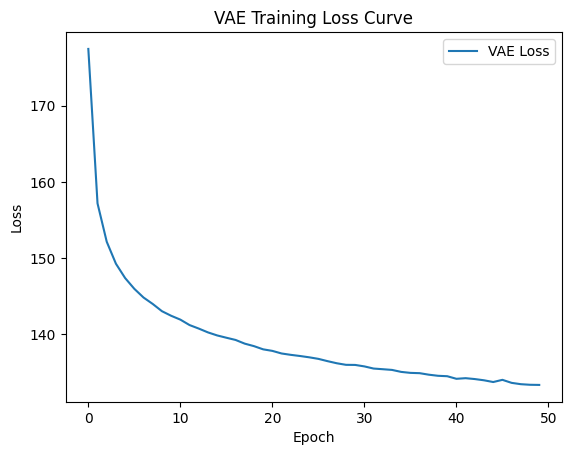

In [11]:

def plot_loss(history, title):
    plt.plot(history['loss'], label='VAE Loss')
    plt.title(f'{title} Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(vae_history, 'VAE')

Image generation

In [12]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

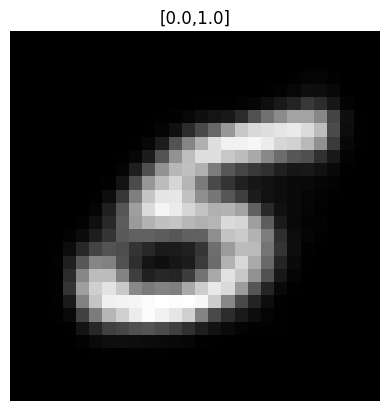

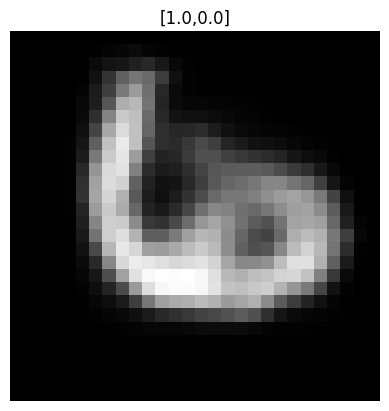

(None, None)

In [13]:
#img1: mean0, var1 / img2: mean1, var0
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

Latent space visualization

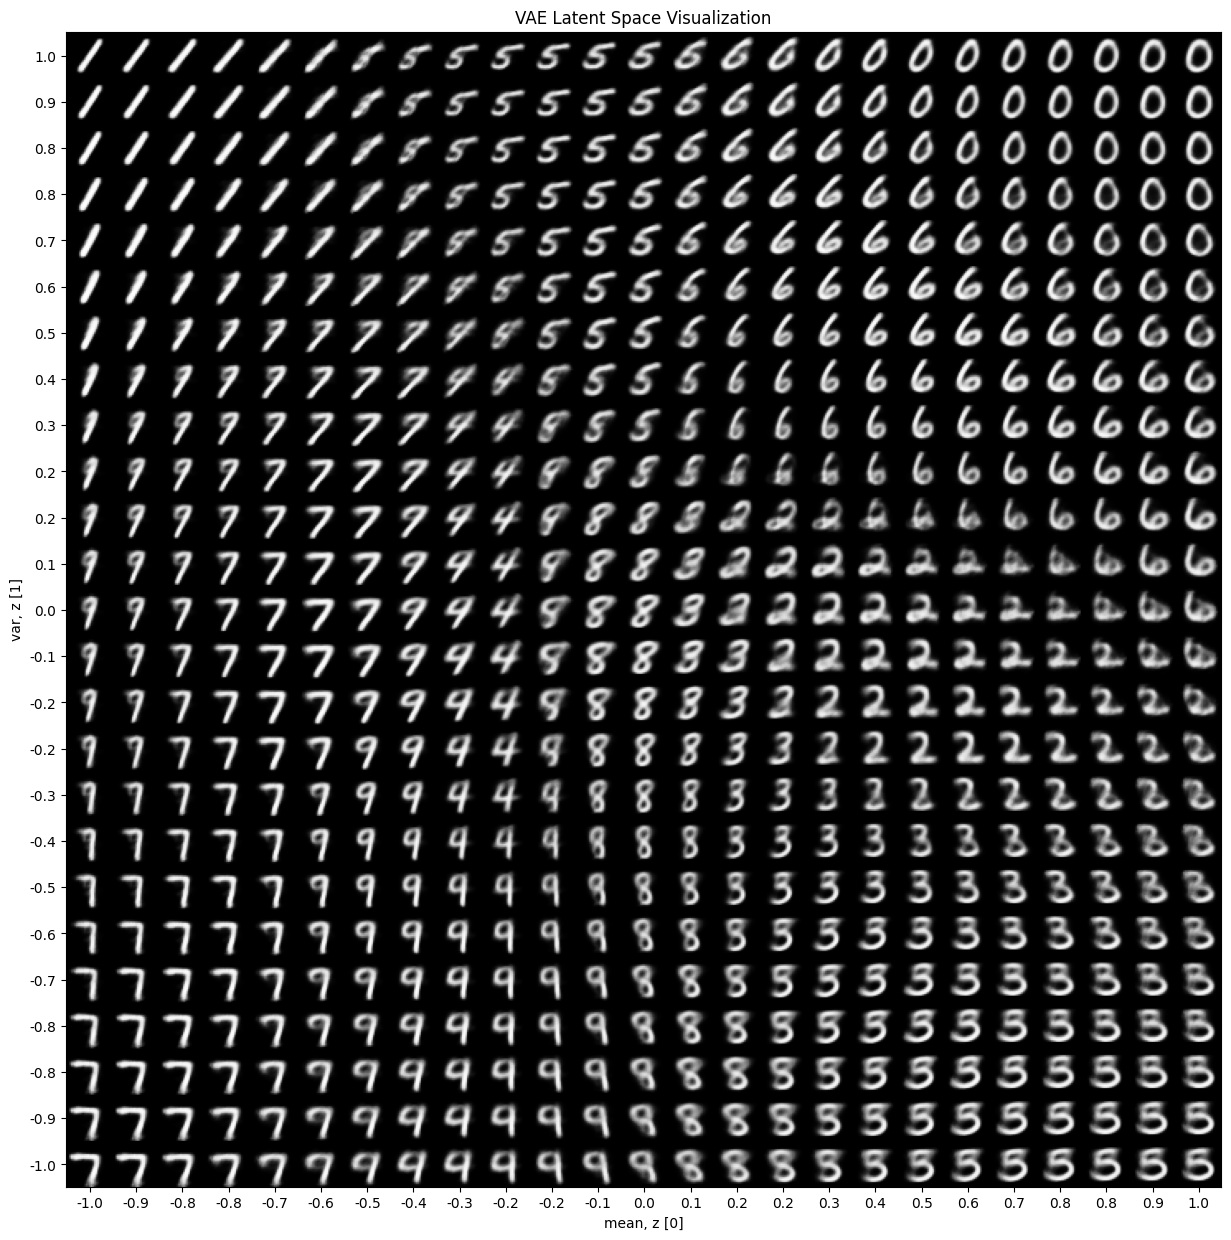

In [14]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

------------------------------------------
**GAN Discriminator and Generator architecture**

In [45]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out
    
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

Hyperparameters

In [46]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

In [47]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


Calculate losses

In [48]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [49]:
# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

Training

In [50]:
import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        # gradients don't have to flow during this step
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 1.3857 | g_loss: 0.7167
Epoch [    1/   50] | d_loss: 1.4047 | g_loss: 1.0927
Epoch [    2/   50] | d_loss: 1.5878 | g_loss: 1.1039
Epoch [    2/   50] | d_loss: 0.8292 | g_loss: 2.3675
Epoch [    3/   50] | d_loss: 0.7603 | g_loss: 3.6413
Epoch [    3/   50] | d_loss: 1.0265 | g_loss: 1.6639
Epoch [    4/   50] | d_loss: 1.3840 | g_loss: 0.6986
Epoch [    4/   50] | d_loss: 1.1315 | g_loss: 1.6281
Epoch [    5/   50] | d_loss: 1.0019 | g_loss: 1.4261
Epoch [    5/   50] | d_loss: 0.9964 | g_loss: 2.5190
Epoch [    6/   50] | d_loss: 1.1974 | g_loss: 0.9748
Epoch [    6/   50] | d_loss: 1.3791 | g_loss: 1.0155
Epoch [    7/   50] | d_loss: 1.4309 | g_loss: 1.1740
Epoch [    7/   50] | d_loss: 1.1787 | g_loss: 1.0376
Epoch [    8/   50] | d_loss: 1.2155 | g_loss: 1.2261
Epoch [    8/   50] | d_loss: 1.3179 | g_loss: 0.9950
Epoch [    9/   50] | d_loss: 1.2760 | g_loss: 1.1677
Epoch [    9/   50] | d_loss: 1.2682 | g_loss: 1.0013
Epoch [   10/   50] | d_loss

Plot losses

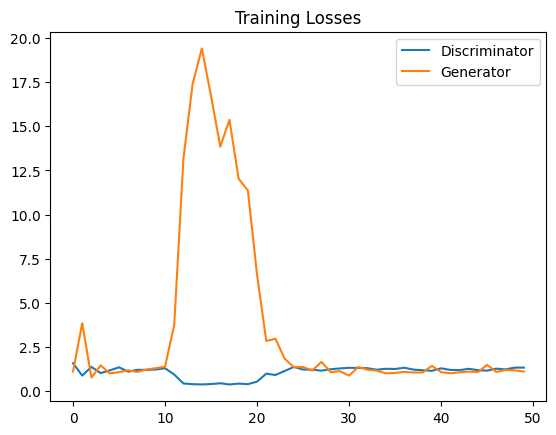

In [51]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [52]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [53]:

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

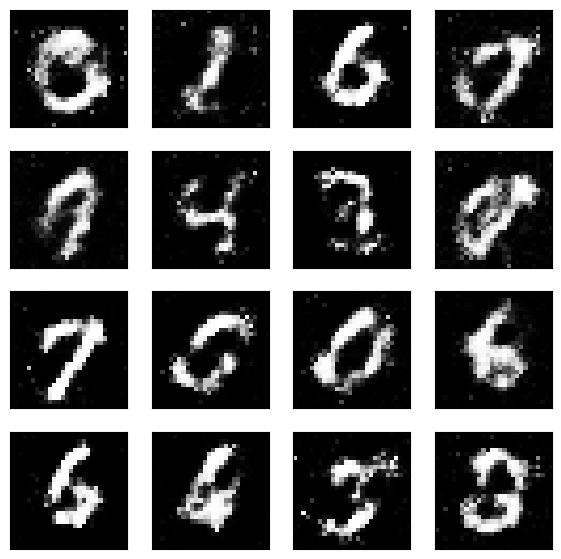

In [54]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

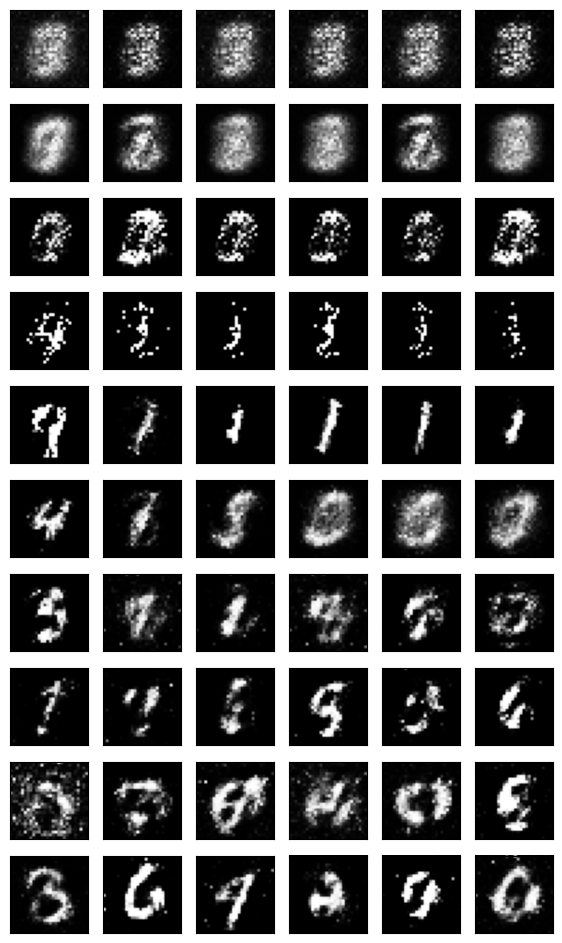

In [55]:
rows = 10 # split epochs into 10, so 50/5 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

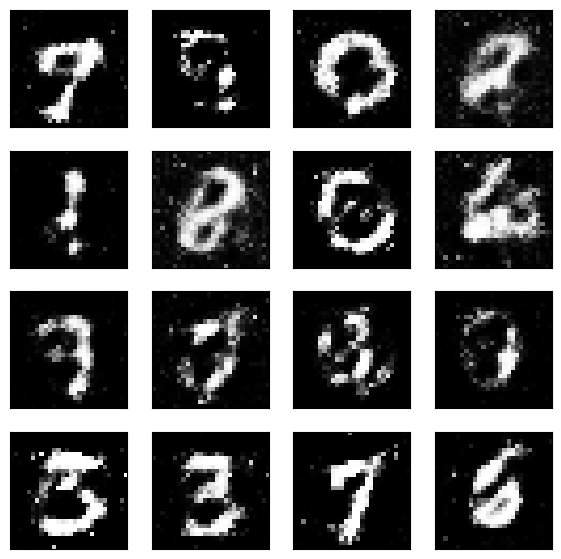

In [56]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

--------------------------------------------
**StyleGAN**

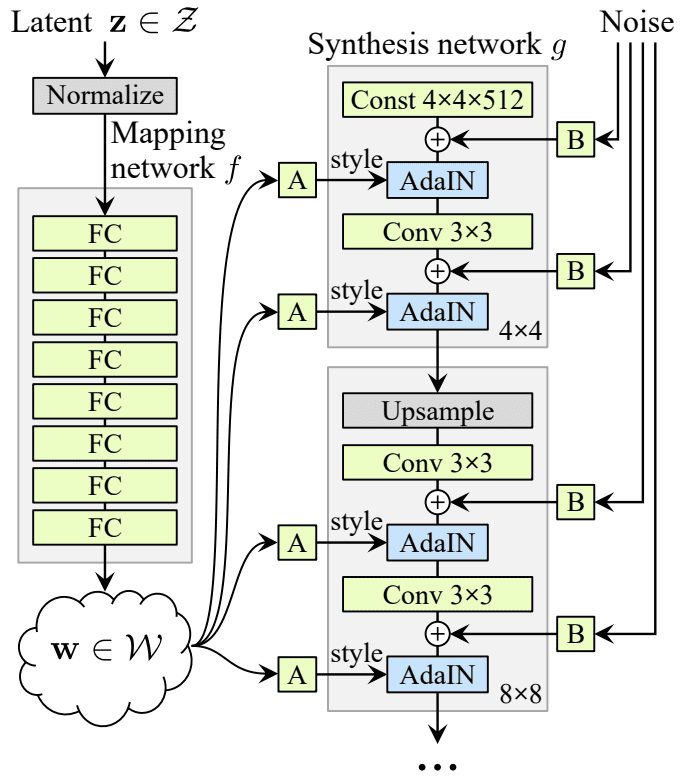

In [61]:
plt.rcParams['figure.figsize'] = (11,11)
plt.rcParams['image.cmap'] = 'gray'

In [77]:
# Dataset
import torchvision.transforms as T
mean = 0.1307
std = 0.3081
dataset = MNIST('data', transform=T.Compose([T.ToTensor(), T.Normalize((mean,), (std,))]), download=True)

In [62]:
from copy import deepcopy

class Scaled_Act(nn.Module):
    to_str = {'Sigmoid' : 'sigmoid', 'ReLU': 'relu', 'Tanh' : 'tanh', 'LeakyReLU': 'leaky_relu'}
    def __init__(self, act, scale = None):
        super().__init__()
        self.act = act
        act_name = Scaled_Act.to_str.get(act._get_name(), act._get_name())
        param = getattr(act, 'negative_slope', None)
        self.scale = scale if scale else torch.nn.init.calculate_gain(act_name, param)

    def forward(self, input):
        return self.scale*self.act(input)

class Equal_LR:
    def __init__(self, name):
        self.name = name

    def compute_norm(module, weight):
        mode = 'fan_in'
        if hasattr(module, 'transposed') and module.transposed:
            mode = 'fan_out'
        return torch.nn.init._calculate_correct_fan(weight, mode)


    def scale_weight(self, module, input):
        setattr(module, self.name, module.scale*module.weight_orig)


    def fn(self, module):
        try:
            weight = getattr(module, self.name)
            module.scale = 1/np.sqrt(Equal_LR.compute_norm(module, weight))
            if isinstance(weight, torch.nn.Parameter):
                # register new parameter -- unscaled weight
                module.weight_orig = nn.Parameter(weight.clone()/module.scale)
                # delete old parameter
                del module._parameters[self.name]
            else:
                # register new buffer -- unscaled weight
                module.register_buffer('weight_orig', weight.clone()/module.scale)
                # delete old buffer
                del module._buffers[self.name]
            module.equalize = module.register_forward_pre_hook(self.scale_weight)
        except:
            pass

    def __call__(self, module):
        new_module = deepcopy(module)
        new_module.apply(self.fn)
        return new_module



def parameters_to_buffers(m):
    params = m._parameters.copy()
    m._parameters.clear()
    for n,p in params.items():
        m.register_buffer(n, p.data)



def grid(array, ncols=8):
    array = np.pad(array, [(0,0),(1,1),(1,1),(0,0)], 'constant')
    nindex, height, width, intensity = array.shape
    ncols = min(nindex, ncols)
    nrows = (nindex+ncols-1)//ncols
    r = nrows*ncols - nindex # remainder
    # want result.shape = (height*nrows, width*ncols, intensity)
    arr = np.concatenate([array]+[np.zeros([1,height,width,intensity])]*r)
    result = (arr.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return np.pad(result, [(1,1),(1,1),(0,0)], 'constant')



class NextDataLoader(torch.utils.data.DataLoader):
    def __next__(self):
        try:
            return next(self.iterator)
        except:
            self.iterator = self.__iter__()
            return next(self.iterator)



def to_tensor(obj, device='cuda'):
    if obj.shape[-1] != 3 and obj.shape[-1] != 1:
        obj = np.expand_dims(obj,-1)
    if obj.ndim < 4:
        obj = np.expand_dims(obj,0)
    t = torch.tensor(np.moveaxis(obj,-1,-3), dtype=torch.float, device=device)
    return t


def to_img(obj):
    array = np.moveaxis(obj.data.cpu().numpy(),-3,-1)
    return array

In [63]:
class Modulated_Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, latent_size,
                 demodulate=True, bias=True, stride=1, padding=0, dilation=1, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, stride,
                         padding, dilation, groups=1,
                         bias=bias, padding_mode='zeros')
        self.demodulate = demodulate
        # style mapping
        self.style = nn.Linear(latent_size, in_channels)
        # required shape might be different in transposed conv
        self.s_broadcast_view = (-1,1,self.in_channels,1,1)
        self.in_channels_dim = 2


    def convolve(self,x,w,groups):
        # bias would be added later
        return F.conv2d(x, w, None, self.stride, self.padding, self.dilation, groups=groups)


    def forward(self, x, v):
        N, in_channels, H, W = x.shape

        # new minibatch dim: (ch dims, K, K) -> (1, ch dims, K, K)
        w = self.weight.unsqueeze(0)

        # compute styles: (N, C_in)
        s = self.style(v) + 1

        # modulate: (N, ch dims, K, K)
        w = s.view(self.s_broadcast_view)*w

        # demodulate
        if self.demodulate:
            sigma = torch.sqrt((w**2).sum(dim=[self.in_channels_dim,3,4],keepdim=True) + 1e-8)
            w = w/sigma

        # reshape x: (N, C_in, H, W) -> (1, N*C_in, H, W)
        x = x.view(1, -1, H, W)

        # reshape w: (N, C_out, C_in, K, K) -> (N*C_out, C_in, K, K) for common conv
        #            (N, C_in, C_out, K, K) -> (N*C_in, C_out, K, K) for transposed conv
        w = w.view(-1, w.shape[2], w.shape[3], w.shape[4])

        # use groups so that each sample in minibatch has it's own conv,
        # conv weights are concatenated along dim=0
        out = self.convolve(x,w,N)

        # reshape back to minibatch.
        out = out.view(N,-1,out.shape[2],out.shape[3])

        # add bias
        if not self.bias is None:
            out += self.bias.view(1, self.bias.shape[0], 1, 1)

        return out


class Up_Mod_Conv(Modulated_Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, latent_size,
                 demodulate=True, bias=True, factor=2):
        assert (kernel_size % 2 == 1)
        padding = (max(kernel_size-factor,0)+1)//2
        super().__init__(in_channels, out_channels, kernel_size, latent_size, demodulate, bias,
                         stride=factor, padding=padding)
        self.output_padding = torch.nn.modules.utils._pair(2*padding - kernel_size + factor)
        # transpose as expected in F.conv_transpose2d
        self.weight = nn.Parameter(self.weight.transpose(0,1).contiguous())
        self.transposed = True
        # taking into account transposition
        self.s_broadcast_view = (-1,self.in_channels,1,1,1)
        self.in_channels_dim = 1

    def convolve(self, x, w, groups):
        return F.conv_transpose2d(x, w, None, self.stride, self.padding, self.output_padding, groups, self.dilation)


class Down_Mod_Conv(Modulated_Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, latent_size,
                 demodulate=True, bias=True, factor=2):
        assert (kernel_size % 2 == 1)
        padding = kernel_size//2
        super().__init__(in_channels, out_channels, kernel_size, latent_size, demodulate, bias,
                         stride=factor, padding=padding)

    def convolve(self, x, w, groups):
        return F.conv2d(x, w, None, self.stride, self.padding, self.dilation, groups=groups)


class Down_Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size,
                 bias=True, factor=2):
        assert (kernel_size % 2 == 1)
        padding = kernel_size//2
        super().__init__(in_channels, out_channels, kernel_size, factor, padding, bias=True)

    def convolve(self, x):
        return F.conv2d(x, w, None, self.stride, self.padding, self.dilation, self.groups)


class Noise(nn.Module):
    def __init__(self):
        super().__init__()
        self.noise_strength = nn.Parameter(torch.zeros(1))

    def forward(self, x, input_noise=None):
        if input_noise is None:
            input_noise = torch.randn(x.shape[0],1,x.shape[2],x.shape[3], device=x.device)
        noise = self.noise_strength*input_noise
        return x + noise

class Mapping(nn.Module):
    def __init__(self, n_layers, latent_size, nonlinearity, normalize=True):
        super().__init__()
        self.normalize = normalize
        self.layers = []
        for idx in range(n_layers):
            layer = nn.Linear(latent_size, latent_size)
            self.add_module(str(idx), layer)
            self.layers.append(layer)
            self.layers.append(nonlinearity)

    def forward(self, input):
        if self.normalize:
            input = input/torch.sqrt((input**2).mean(dim=1, keepdim=True) + 1e-8)
        for module in self.layers:
            input = module(input)
        return input


class G_Block(nn.Module):
    def __init__(self, in_fmaps, out_fmaps, kernel_size, latent_size, nonlinearity, factor=2, img_channels=3):
        super().__init__()
        inter_fmaps = (in_fmaps + out_fmaps)//2
        self.upconv = Up_Mod_Conv(in_fmaps, inter_fmaps, kernel_size, latent_size,
                                      factor=factor)
        self.conv = Modulated_Conv2d(inter_fmaps, out_fmaps, kernel_size, latent_size,
                                     padding=kernel_size//2)
        self.noise = Noise()
        self.noise2 = Noise()
        self.to_channels = Modulated_Conv2d(out_fmaps, img_channels, kernel_size=1,
                                      latent_size=latent_size, demodulate = False)
        self.upsample = nn.Upsample(scale_factor=factor, mode='bilinear', align_corners=False)
        self.act = nonlinearity

    def forward(self, x, v, y=None, input_noises=None):
        x = self.noise(self.upconv(x,v), None if (input_noises is None) else input_noises[:,0])
        x = self.act(x)
        x = self.noise2(self.conv(x,v), None if (input_noises is None) else input_noises[:,1])
        x = self.act(x)
        if not y is None:
            y = self.upsample(y)
        else:
            y = 0
        y = y + self.to_channels(x,v)
        return x, y

class D_Block(nn.Module):
    def __init__(self, in_fmaps, out_fmaps, kernel_size, nonlinearity, factor=2):
        super().__init__()
        inter_fmaps = (in_fmaps + out_fmaps)//2
        self.conv = nn.Conv2d(in_fmaps, inter_fmaps, kernel_size, padding=kernel_size//2)
        self.downconv = Down_Conv2d(inter_fmaps, out_fmaps, kernel_size, factor=factor)
        self.skip = Down_Conv2d(in_fmaps, out_fmaps, kernel_size=1, factor=factor)
        self.act = nonlinearity

    def forward(self, x):
        t = x
        x = self.conv(x)
        x = self.act(x)
        x = self.downconv(x)
        x = self.act(x)
        t = self.skip(t)
        return (x + t)/ np.sqrt(2)


class Minibatch_Stddev(nn.Module):
    def __init__(self, group_size=4):
        super().__init__()
        self.group_size = group_size

    def forward(self, x):
        s = x.shape
        t = x.view(self.group_size, -1, s[1], s[2], s[3])
        t = t - t.mean(dim=0, keepdim=True)
        t = torch.sqrt((t**2).mean(dim=0) + 1e-8)
        t = t.mean(dim=[1,2,3], keepdim=True) # [N/G,1,1,1]
        t = t.repeat(self.group_size,1,1,1).expand(x.shape[0],1,*x.shape[2:])
        return torch.cat((x,t),dim=1)

In [64]:
def G_logistic_ns(fake_logits):
    return -F.logsigmoid(fake_logits).mean() # -log(D(G(z)))


def D_logistic(real_logits, fake_logits):
    return torch.mean(-F.logsigmoid(real_logits) + F.softplus(fake_logits)) # -log(D(x)) - log(1-D(G(z)))

def R1_reg(real_imgs, real_logits):
    grads = torch.autograd.grad(real_logits.sum(), real_imgs, create_graph=True)[0]
    return torch.mean((grads**2).sum(dim=[1,2,3]))

class Path_length_loss(nn.Module):
    def __init__(self, decay=0.01):
        super().__init__()
        self.decay = decay
        self.avg = 0

    def forward(self, dlatent, gen_out):
        # Compute |J*y|.
        noise = torch.randn(gen_out.shape, device=gen_out.device)/np.sqrt(np.prod(gen_out.shape[2:])) #[N,Channels,H,W]
        grads = torch.autograd.grad((gen_out * noise).sum(), dlatent, create_graph=True)[0]  #[N, num_layers, dlatent_size]
        lengths = torch.sqrt((grads**2).mean(2).sum(1)) #[N]
        # Update exp average. Lengths are detached
        self.avg = self.decay*torch.mean(lengths.detach()) + (1-self.decay)*self.avg
        return torch.mean((lengths - self.avg)**2)


def Noise_reg(noise_maps, min_res=8):
    loss = 0
    for nmap in noise_maps:
        res = nmap.shape[-1]
        while res > 8:
            loss += ( torch.mean(nmap * nmap.roll(shifts=1, dims=-1), dim=[-1,-2])**2
                    + torch.mean(nmap * nmap.roll(shifts=1, dims=-2), dim=[-1,-2])**2 ).sum()
            nmap = F.avg_pool2d(nmap.squeeze(), 2)
            res = res//2
    return loss

In [65]:
class Generator(nn.Module):
    def __init__(self, min_res, max_res, min_fmaps, max_fmaps, act, 
                 k_size, blocks, img_channels, latent_size, n_layers, style_mixing_prob = 0.8,
                 dlatent_avg_beta = 0.995, weights_avg_beta=0.99, **kwargs):
        super().__init__()
        dres = min_res*2**blocks - max_res
        assert dres >= 0
        # building mapping net
        self.latent_size = latent_size
        self.mapping = Mapping(n_layers, latent_size, act)
        # learnable const
        self.const = nn.Parameter(torch.randn(max_fmaps, min_res, min_res))
        # building main layers
        fmaps = np.linspace(max_fmaps, min_fmaps, blocks+1).astype('int')
        self.layers = []
        for i in range(blocks):
            layer = G_Block(fmaps[i],fmaps[i+1], k_size, latent_size, act, img_channels=img_channels)
            self.add_module(str(i), layer)
            self.layers.append(layer)
        if dres > 0:
            self.crop = torch.nn.ZeroPad2d(-dres//2)
        # style mixing
        self.style_mixing_prob = style_mixing_prob 
        # running average of dlatents 
        self.dlatent_avg_beta = dlatent_avg_beta
        self.register_buffer('dlatent_avg', torch.zeros(latent_size))
        # running average of weights
        self.weights_avg_beta = weights_avg_beta
        self.Src_Net = deepcopy(self).apply(parameters_to_buffers)
        self.Src_Net.train(False)      
        
        
    # update running average of weights
    def update_avg_weights(self):
        params = dict(self.named_parameters())
        buffers = dict(self.named_buffers())
        for n,b in self.Src_Net.named_buffers():
            try:
                b.data.copy_(self.weights_avg_beta*b + (1-self.weights_avg_beta)*params[n])
            except:
                b.data.copy_(buffers[n])
                
    def load_avg_weights(self):
        buffers = dict(self.Src_Net.named_buffers())
        for n,p in self.named_parameters():
            p.data.copy_(buffers[n])
            
            
    # sample dlatents
    def sample_dlatents(self, n):
        v = self._sample_dlatents(n)
        if self.training and self.style_mixing_prob > 0:
            v = self._bcast_dlatents(v)
            l = len(self.layers)
            cut_off = torch.randint(l-1,())
            v2 = self._bcast_dlatents(self._sample_dlatents(n))
            mask = torch.empty(n, dtype=torch.bool).bernoulli_(self.style_mixing_prob).view(-1, 1) \
                   * (torch.arange(l)>cut_off)
            v = torch.where(mask.unsqueeze(-1).to(device=v.device), v2, v)
        return v
    
    def _sample_dlatents(self, n):
        device = self.const.device
        z = torch.randn(n, self.latent_size).to(device)
        v = self.mapping(z)
        # update dlatent average
        if self.training:
            self.dlatent_avg = self.dlatent_avg_beta*self.dlatent_avg + (1-self.dlatent_avg_beta)*v.data.mean(0)
        return v
    
    def _bcast_dlatents(self, v):
        # broadcast dlatents [N, dlatent_size] --> [N, num_layers, dlatent_size] 
        return v.unsqueeze(1).expand(-1, len(self.layers), -1)
    
    
    # generate from dlatents and input noises (optionally)
    def generate(self, v, input_noises=None):
        x = self.const.expand(v.shape[0], *self.const.shape).contiguous()
        input_noises = input_noises if input_noises else [None]*len(self.layers)
        y = None
        if v.ndim < 3:
            v = self._bcast_dlatents(v)
        for i,layer in enumerate(self.layers):
            x, y = layer(x,v[:,i],y, input_noises[i])  
        if hasattr(self, 'crop'):
            y = self.crop(y)
        return y
    
    
    # for training
    def sample(self, n):
        dlatents = self.sample_dlatents(n)
        x = self.generate(dlatents)
        return x
            
    
    # for evaluation
    def sample_images(self,n, truncation_psi=1):
        with torch.no_grad():
            v = self.Src_Net.sample_dlatents(n)
            # truncation trick
            if truncation_psi < 1:
                v = self.dlatent_avg + truncation_psi*(v-self.dlatent_avg)
            images = to_img(self.Src_Net.generate(v))
        return images

In [66]:
class Discriminator(nn.Module):
    def __init__(self, min_res, max_res, min_fmaps, max_fmaps, act, 
                 k_size, blocks, img_channels, dense_size=128, **kwargs):
        super().__init__()
        assert max_res <= min_res*2**blocks and max_res >= (min_res-1)*2**blocks
        # building layers
        fmaps = np.linspace(min_fmaps, max_fmaps, blocks+1).astype('int')
        self.from_channels = nn.Conv2d(img_channels, fmaps[0], 1)
        self.layers = []
        for i in range(blocks):
            layer = D_Block(fmaps[i],fmaps[i+1], k_size, act)
            self.add_module(str(i), layer)
            self.layers.append(layer)
        self.minibatch_sttdev = Minibatch_Stddev()
        self.conv = nn.Conv2d(fmaps[-1]+1,fmaps[-1], 3)
        self.dense = nn.Linear(fmaps[-1]*(min_res-2)**2, dense_size)
        self.output = nn.Linear(dense_size, 1)
        self.act = act
    
    
    def get_score(self, imgs):
        x = self.act(self.from_channels(imgs))
        for layer in self.layers:
            x = layer(x)
        x = self.minibatch_sttdev(x)
        x = self.act(self.conv(x))
        x = x.view(x.shape[0],-1)
        x = self.act(self.dense(x))
        x = self.output(x)
        return x

In [67]:
def train(G, D, dataset, max_iter, batch_size, 
          G_opt_args, D_opt_args, mapping_opt_args,
          D_steps, pl_weight, r1_weight,
          r1_interval, pl_interval, val_interval, num_workers, pl_batch_part, checkpoint=None):
    
    pl_batch = int(pl_batch_part*batch_size)
    device = next(D.parameters()).device
    Path_length_reg = Path_length_loss()

    # create dataloader
    dataloader = NextDataLoader(dataset, batch_size, num_workers=num_workers)
    mean = dataset.transforms.transform.transforms[1].mean[0]
    std = dataset.transforms.transform.transforms[1].std[0]
    
    # load state
    if checkpoint:
        G.load_state_dict(checkpoint['G'])
        D.load_state_dict(checkpoint['D'])
        Path_length_reg.avg = checkpoint['pl_loss_avg']
    
    # create optimizer
    G_params = []
    for n,m in G.named_children():
        if n != 'mapping':
            G_params.extend(m.parameters())
    gen_optimizer = torch.optim.Adam([{'params': G_params},
                                  {'params': G.mapping.parameters(), **mapping_opt_args},
                                  {'params': G.const, **mapping_opt_args},
                                  ], **G_opt_args)
    disc_optimizer = torch.optim.Adam(D.parameters(), **D_opt_args)
    
    G.train()
    D.train()
    
    for i in tqdm(range(max_iter)):
        # discriminator update
        for j in range(D_steps):
            real_imgs = next(dataloader)[0].to(device)
            real_imgs.requires_grad = True
            fake_imgs = G.sample(real_imgs.shape[0])
            real_scores = D.get_score(real_imgs)
            fake_scores = D.get_score(fake_imgs)
            loss =  D_logistic(real_scores, fake_scores)
            if i % r1_interval == 0 and j == D_steps-1:
                loss += r1_weight*r1_interval*R1_reg(real_imgs, real_scores)
            real_imgs.requires_grad = False
            disc_optimizer.zero_grad()
            loss.backward()
            disc_optimizer.step()


        # generator update
        dlatent = G.sample_dlatents(batch_size)   
        if i % pl_interval == 0:
            # hack to compute path length loss with smaller minibatch (for reducing memory consumption)
            dlatent_part1, dlatent_part_2 = dlatent[:pl_batch], dlatent[pl_batch:]
            fake_imgs = G.generate(torch.cat((dlatent_part1, dlatent_part_2), 0))
            fake_scores = D.get_score(fake_imgs)
            loss = G_logistic_ns(fake_scores) \
                   + pl_weight*pl_interval*Path_length_reg(dlatent_part1, fake_imgs[:pl_batch])
        else:
            fake_imgs = G.generate(dlatent)
            fake_scores = D.get_score(fake_imgs)
            loss = G_logistic_ns(fake_scores)  
        gen_optimizer.zero_grad()
        loss.backward()
        gen_optimizer.step()   
        # updating running average   
        G.update_avg_weights()
        
        if i % val_interval == 0:
            display.clear_output(wait=True)
            # print pictures
            gen = G.sample_images(32)*std+mean
            plt.imshow(grid(gen).squeeze())
            plt.show()
            # print prob distribution
            plt.figure(figsize=(5,5))
            plt.title('Generated vs real data')
            plt.hist(torch.sigmoid(real_scores.data).cpu().numpy(), label='D(x)', alpha=0.5,range=[0,1])
            plt.hist(torch.sigmoid(fake_scores.data).cpu().numpy(), label='D(G(z))',alpha=0.5,range=[0,1])
            plt.legend(loc='best')
            plt.show()


        if i % (20*val_interval) == 0:
            torch.save({
                        'G': G.state_dict(),
                        'D': D.state_dict(),
                        'pl_loss_avg': Path_length_reg.avg.item()
                        }, 'checkpoint.pt')

In [68]:
img_channels = 1
n_layers = 4  # number of layers in mapping from latents to dlatents
latent_size = 160 # for simplicity dim of latent space = dim of dlatent space

In [70]:
min_res = 4 # resolution from which the synthesis starts
max_res = 28 # out resolution 
blocks = 3 # number of building blocks for both the generator and dicriminator
k_size = 3 # convolutions kernel size
max_fmaps = 128 # number of feature maps at the beginning of generation
min_fmaps = 64  # number of feature maps before going to the number of channels
weights_avg_beta=0.995 # beta for running average of generator weights
act = Scaled_Act(nn.LeakyReLU(0.2)) # activation function

In [80]:
device = 'cuda'

train_params = {
    'max_iter': 5000, 
    'batch_size' : 16,
    'G_opt_args' : {'lr' : 0.001, 'betas' : (0.1, 0.99)}, 
    'D_opt_args' : {'lr' : 0.001, 'betas' : (0, 0.99), 'eps' : 1e-08}, 
    'mapping_opt_args' : {'lr' : 1e-5}, 
    'D_steps': 1, 
    'pl_weight': 2, 
    'r1_weight': 8, 
    'pl_batch_part': 0.5,
    'pl_interval': 4, 
    'r1_interval': 16, 
    'num_workers': 2, 
    'val_interval': 20 }

In [81]:
G = Generator(min_res, max_res, min_fmaps, max_fmaps, act, 
              k_size, blocks, img_channels, latent_size, n_layers, weights_avg_beta=weights_avg_beta).to(device)

D = Discriminator(min_res, max_res, min_fmaps, max_fmaps, act, 
                   k_size, blocks, img_channels).to(device)

In [82]:
G = Equal_LR('weight')(G)
D = Equal_LR('weight')(D)

In [83]:
def init_weights(m):
    if hasattr(m, 'weight_orig'):
        torch.nn.init.normal_(m.weight_orig)
    if hasattr(m, 'bias'):
        torch.nn.init.zeros_(m.bias)
        
G.apply(init_weights)
D.apply(init_weights)

Discriminator(
  (from_channels): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  (0): D_Block(
    (conv): Conv2d(64, 74, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downconv): Down_Conv2d(74, 85, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (skip): Down_Conv2d(64, 85, kernel_size=(1, 1), stride=(2, 2))
    (act): Scaled_Act(
      (act): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): D_Block(
    (conv): Conv2d(85, 95, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downconv): Down_Conv2d(95, 106, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (skip): Down_Conv2d(85, 106, kernel_size=(1, 1), stride=(2, 2))
    (act): Scaled_Act(
      (act): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): D_Block(
    (conv): Conv2d(106, 117, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downconv): Down_Conv2d(117, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (skip): Down_Conv2d(106, 128, kernel_size=(1, 1), stride=(2, 2))
    (act): Sc

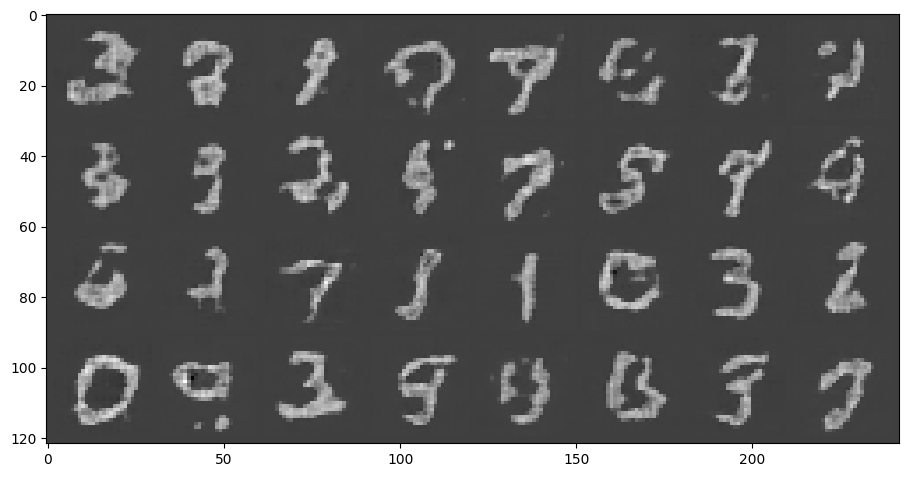

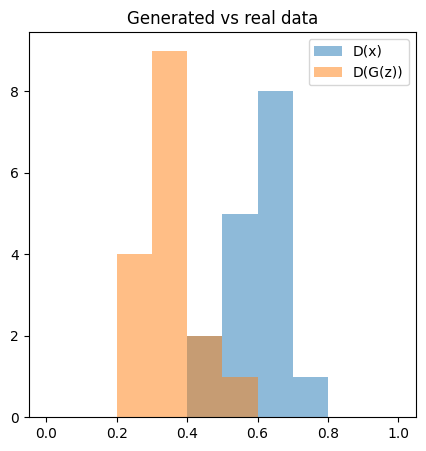

100%|██████████| 5000/5000 [08:42<00:00,  9.57it/s]


In [84]:
train(G, D, dataset, **train_params)

In [85]:
checkpoint = torch.load('checkpoint.pt')
G.load_state_dict(checkpoint['G'])
G.load_avg_weights()
G.eval();

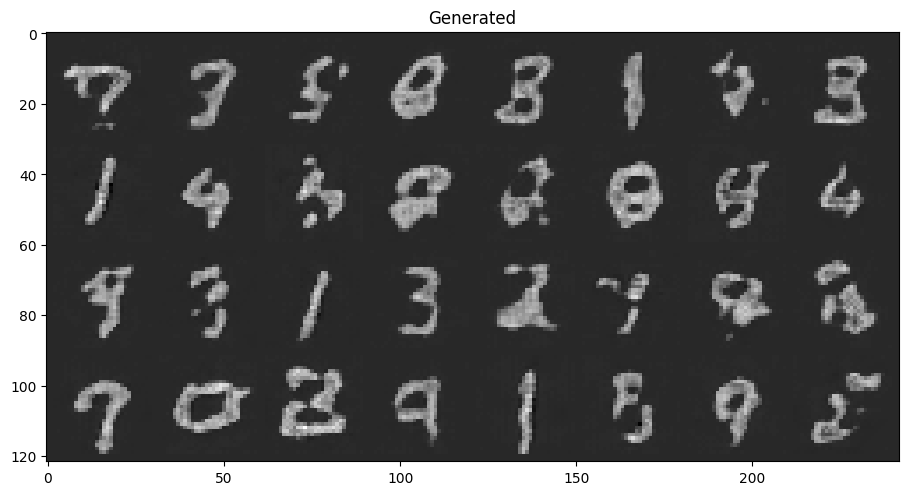

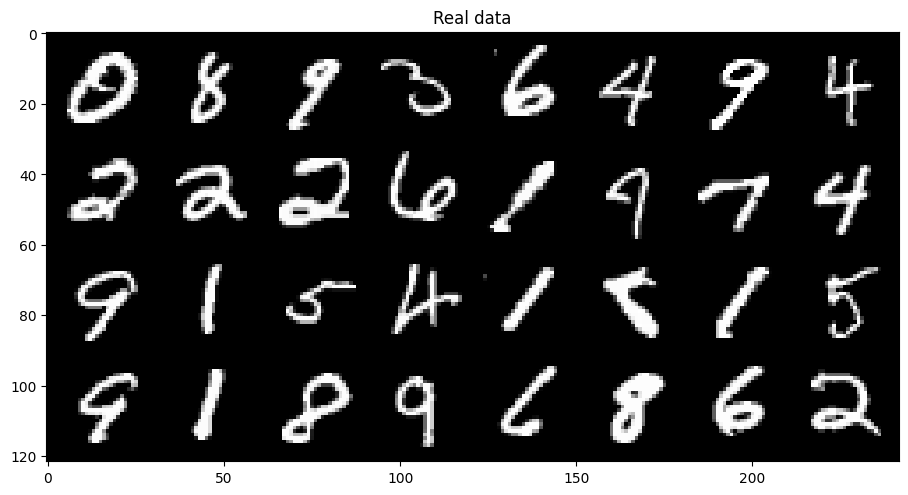

In [86]:
plt.title('Generated')
plt.imshow(grid(G.sample_images(32, truncation_psi=0.9)*std+mean).squeeze())
plt.show()

plt.title('Real data')
i = np.random.randint(50000)
real_imgs = dataset.data[i:32+i].unsqueeze(-1)
plt.imshow(grid(real_imgs).squeeze())
plt.show()

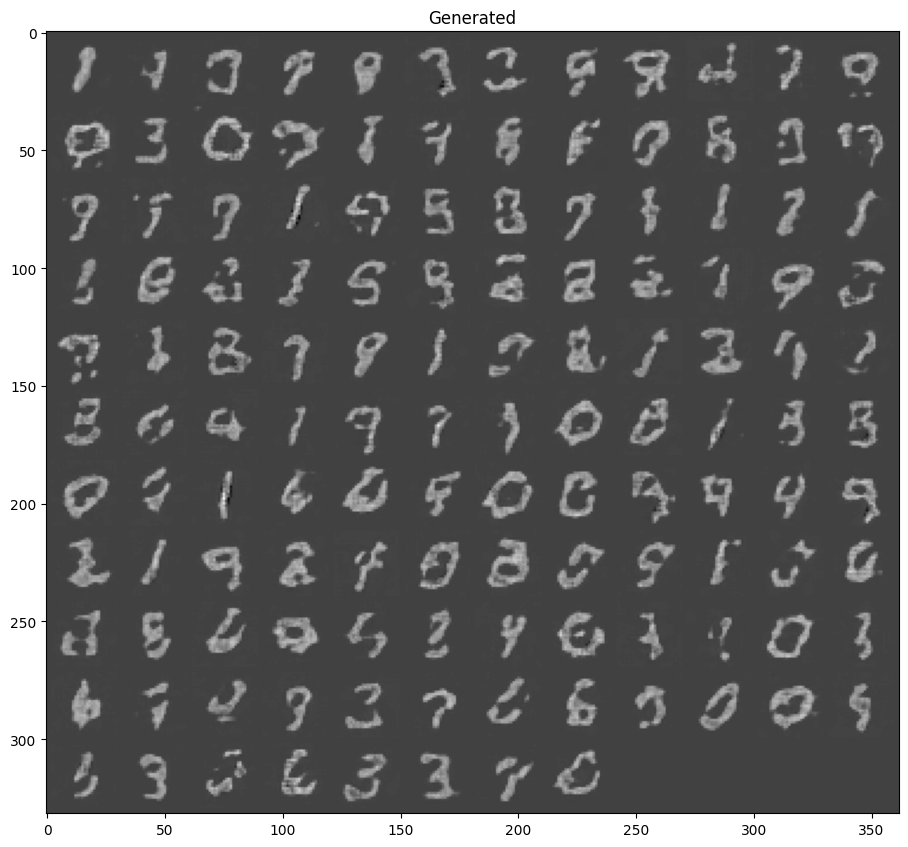

In [87]:
plt.title('Generated')
#Compare affects of truncation value
plt.imshow(grid(G.sample_images(128, truncation_psi=0.9)*std+mean, ncols=12).squeeze())
plt.show()

--------------------------------------------------------------------------------------------------------
- 1-mas epocas
- 2-curvas precision
- 3-cambiar visualizacion
- 4-gan vector bidimensional (2d y espacio) 
    matrices e imagenes
- 5- imagen numeros con la gan

buscar sobre
- 6- gan inversion

- https://sertiscorp.medium.com/gan-inversion-a-brief-walkthrough-part-i-bc2ee1b73253
- https://github.com/weihaox/GAN-Inversion
- https://github.com/eriklindernoren/PyTorch-GAN
- https://github.com/gonzalorecio/MNIST-latent-representations
- https://github.com/MorvanZhou/mnistGANs/tree/main?tab=readme-ov-file#StyleGAN
- https://machinelearningmastery.com/introduction-to-style-generative-adversarial-network-stylegan/